# Images as Data Lab

Welcome to the images as data lab! By the end of this lecture, you will have

1. Combined images to make new images
2. Gained intuition for image template matching
3. Used convolution for feature detection
4. Used max-pooling to downsample images

Let's get started!

## Load Images

In [1]:
from IPython.display import display
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import array_to_img, img_to_array
from keras.utils.np_utils import to_categorical
from scipy.signal import correlate2d
from skimage.measure import block_reduce

Using TensorFlow backend.


In [2]:
[X_mnist, y_mnist], _ = mnist.load_data()
X_mnist = np.expand_dims(X_mnist, axis=1).astype(np.float)
imgs = [array_to_img(x, data_format='channels_first').resize(size=[128, 128]) for x in X_mnist]
X = np.array([img_to_array(img) for img in imgs])

#### Consider the Following Two Images...

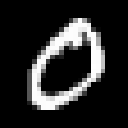

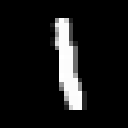

In [3]:
img0, img6 = imgs[1], imgs[6]

display(img0)
display(img6)

### Questions

Before doing anything, what will the resulting image will look like when we...

1. Add them?
2. Subtract them?
    1. Does the order of the subtraction matter? That is, will the resulting image look different depending on the order of the subtraction?
3. Multiply them?

> 1. See both images.  Higher intensity where they cross.
> 2. The one you subtract will have a lower intensity.  
> 3. See only where they cross.

### Tasks

- Compute these images to verify your answer

### Requirements

- Threshold each resulting image so that their minimum value is `0`

### Hints

- Recall how to convert back and forth between numpy arrays and PIL images. You will be doing this often during this lab.

![Converting Images](images/Converting%20Images.png)

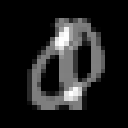

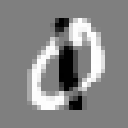

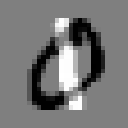

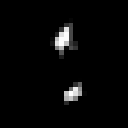

In [4]:
v0 = img_to_array(img0)
v1 = img_to_array(img6)
display(array_to_img(v0 + v1))
display(array_to_img(v0 - v1))
display(array_to_img(v1 - v0))
display(array_to_img(v0 * v1))

#### Consider the following three images...

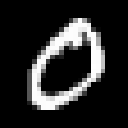

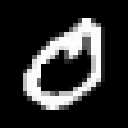

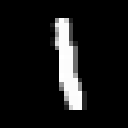

In [5]:
img0, img0_, img1 = imgs[1], imgs[21], imgs[6]

display(img0)
display(img0_)
display(img1)

### Questions

- Will `np.sum(x0*x0_) > np.sum(x0*x1)` or `np.sum(x0*x0_) < np.sum(x0*x1)`? Justify your answer with intuition.

> 0/0 will be greater than 0/1 because the zeros are more similar than zero is to one.  

### Tasks

- Compute these quantities to verify your answer

In [6]:
v0 = img_to_array(img0)
v0_ = img_to_array(img0_)
v1 = img_to_array(img1)
print('0/0:', (v0 * v0_).sum())
print('0/1:', (v0 * v1).sum())
(v0 * v0_).sum() > (v0 * v1).sum()

0/0: 1.3416e+08
0/1: 2.80862e+07


True

### Questions

- Consider the following keras architecture for classifying MNIST digits

![MNIST Keras](images/MNIST%20Keras.png)
and that we have optimized $\mathbf{W}$ to produce high scores for the correct digit class.

If we take $w_i$ and *reshape it back into a $28 \times 28$ image* and display it, what might it look like? Why might this be the case?

> Each w_i might look like one of the 10 numbers.  That way the w_i will have the highest dot product when it is multiplied by the number that it looks like.  

### Tasks

- Define this architecture and train this model for 5 epochs in keras
- Reshape each $w_i$ back to a $28 \times 28$ image and display it

### Hints

- Use a softmax layer + categorical cross entropy loss
- Transform `y` from a `1darray` to a categorical `2darray` with `keras.utils.np_utils.to_categorical()`
    - Use the `28x28` `X_minst` variable as opposed to the `128x128` `X` variable in scope
- Use `keras.layers.Layer.get_weights()` to get the weights of a layer

In [7]:
y = to_categorical(y_mnist, num_classes=10)
y.shape

(60000, 10)

In [8]:
X_vec = X_mnist.reshape(X_mnist.shape[0], X_mnist.shape[2]*X_mnist.shape[3])
X_vec.shape

(60000, 784)

In [9]:
X_vec /= 255

model.add(Flatten(input_shape[28, 28, 1]))   # Can use this as the first layer.  

In [10]:
model = Sequential()
model.add(Dense(units=10, activation='softmax', input_shape=(X_vec.shape[1], )))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850.0
Trainable params: 7,850
Non-trainable params: 0.0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
batch_size = 128
epochs = 5 # 20 is good number; But let's limit it to 5
history = model.fit(X_vec, y, batch_size=batch_size, epochs=epochs, verbose=True)

Epoch 1/5
60000/60000 [==============================] - 1s - loss: 0.6932 - acc: 0.8271      

In [13]:
w0, w1 = model.get_weights()
print(w0.shape)
print(w1.shape)

(784, 10)
(10,)


The bias value for a class will help us with class imbalances.  If there is class imbalance, before we even see a image, we have an idea of how probable each digit is.  

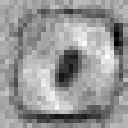

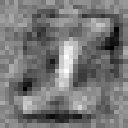

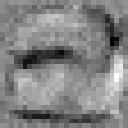

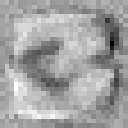

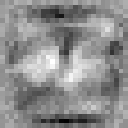

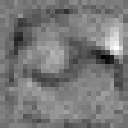

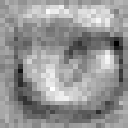

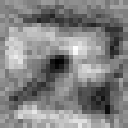

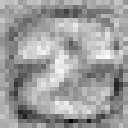

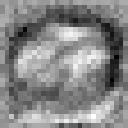

In [14]:
for i in range(10):
    wi = w0[:, i]
    im = array_to_img(wi.reshape((28, 28, 1))).resize(size=[128, 128])
    display(im)

### Questions

- List two advantages of using a linear classifier for images. List two disadvantages.

> Advantages: 1. Explainable.  2. Fast training.  

> Disadvantages: 1. If you just feed individual pixels, you are unable to capture information about surrounding cells well.  2. If you do perform manual feature extraction, it requires a lot of expertise and is time consuming / difficult.  

- Compare and contrast a logistic regression MNIST classifier and a KNN classifier. When might a KNN classifier outperform linear regression?

> We can think of the logistic classifier above using the dot product of the new image with each of the average images as very similar to cosine similarity (just not normalizing the dot product).  The image is classified to the average image to which it is most similar.  

> Alternatively, we could use KNN with cosine similarity to classify the new image with the dominant label from the nearest neighbors.  

> These approaches are much alike.  The difference is computing similarity with the average versus the nearest neighbors.  

> KNN would outperform logistic regression, for example, if there are two different ways people write the number 2.  Logistic regression would use the average 2 to compare against all other twos, which may not be a great fit for either type of 2.  However, KNN compares to the closest neighbors, so it could find nearest neighbors appropriately for each type of 2.  

## Averaging Images

### Questions

- What do you think the resulting image of averaging all images of `0` would look like? What about the average image for other numbers?

> I think it would look like a typical 0.  
> I think the other numbers would look like a typical number.  

### Tasks

- Compute the average image for every number and display it to verify your answer

### Hints

- Start by just handling `0` and then wrap this logic in a `for` loop to handle the remaining numbers

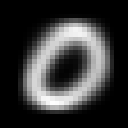

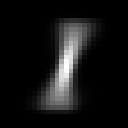

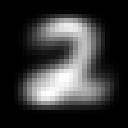

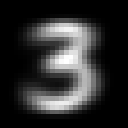

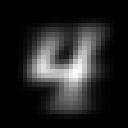

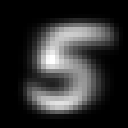

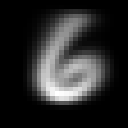

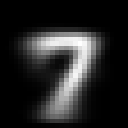

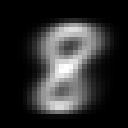

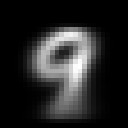

In [15]:
for i in range(10):
    temp = X[y_mnist == i]
    avg = temp.mean(axis=0)
    display(array_to_img(avg))

### Questions

- How do these images compare with the columns of $W$ from the previous section? Do they look similar? Why might this be the case?

> They look kind of similar.  I think they would look more similar if the model fit even better.  

> It would make sense that they would be similar, because the average image for the number would give a high dot products for images from that number.  

# Convolution

Consider the filter $
F =
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{bmatrix}
$
and the image $x =$

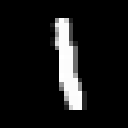

In [16]:
img1

- What will the resuling activation map $x \star F$ look like? What types of patches does $F$ produce the strongest activations for?

> The result will still look like img1, meaning you will be able to tell it is a 1.  But, it will have strongest activations along the vertical lines.  

### Tasks

- Convolve $w$ with $x$ and display the result

### Hints

- Use `scipy.signal.correlate2d()` with `mode='valid'`
- Since `scipy.signal.correlate2d()` expects a `2darray`, you will have to remove the color dimension from `x` with indexing and then tack it back on to the activation map returned by `scipy.signal.correlate2d()` with `np.expand_dims(axis=0)`

In [17]:
f_temp = """-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1""".replace('&', '').split('\\')
f = np.asarray([_.split('  ') for _ in f_temp], dtype=np.float32)

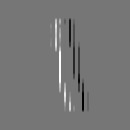

In [18]:
c = correlate2d(img_to_array(img1).reshape(128, 128), f)
c = np.expand_dims(c, axis=2)
array_to_img(c)

### Questions

- What about the filters
$
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{bmatrix},
\
\begin{bmatrix}
1 & 0 & -1 \\
1 & 0 & -1 \\
1 & 0 & -1
\end{bmatrix},
\
\begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix},
\
\begin{bmatrix}
1 & 1 & 1 \\
0 & 0 & 0 \\
-1 & -1 & -1
\end{bmatrix},
\
\begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & -1.5 \\
1 & -1.5 & 0
\end{bmatrix},
\
\begin{bmatrix}
1 & -1.5 & 0 \\
0 & 1 & -1.5 \\
0 & 0 & 1
\end{bmatrix}?
$

### Tasks

- Convolve these filters with $x$ and display the resulting activation maps to verify your answer

### Hints

- Write a function that convolves a filter with an image and displays the resulting activation map

In [19]:
def convolve(f_str, img):
    f_list = f_str.replace('&', '').split('\\')
    f = np.asarray([_.split('  ') for _ in f_list], dtype=np.float32)
    print(f)
    
    c = correlate2d(img_to_array(img).reshape(128, 128), f)
    c = np.expand_dims(c, axis=2)
    display(array_to_img(c))

[[-1.  0.  1.]
 [-1.  0.  1.]
 [-1.  0.  1.]]


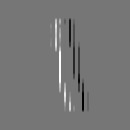

[[ 1.  0. -1.]
 [ 1.  0. -1.]
 [ 1.  0. -1.]]


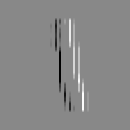

[[-1. -1. -1.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]]


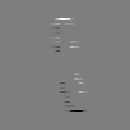

[[ 1.  1.  1.]
 [ 0.  0.  0.]
 [-1. -1. -1.]]


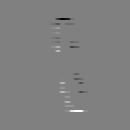

[[ 0.   0.   1. ]
 [ 0.   1.  -1.5]
 [ 1.  -1.5  0. ]]


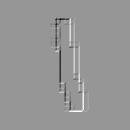

[[ 1.  -1.5  0. ]
 [ 0.   1.  -1.5]
 [ 0.   0.   1. ]]


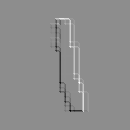

In [20]:
convolve("""-1 & 0 & 1 \\-1 & 0 & 1 \\-1 & 0 & 1""", img1)
convolve("""1 & 0 & -1 \\1 & 0 & -1 \\1 & 0 & -1""", img1)
convolve("""-1 & -1 & -1 \\0 & 0 & 0 \\1 & 1 & 1""", img1)
convolve("""1 & 1 & 1 \\0 & 0 & 0 \\-1 & -1 & -1""", img1)
convolve("""0 & 0 & 1 \\0 & 1 & -1.5 \\1 & -1.5 & 0""", img1)
convolve("""1 & -1.5 & 0 \\0 & 1 & -1.5 \\0 & 0 & 1""", img1)

## Pooling

We can think of a single convolutional image as a feature detector. For example, in the previous section we considered convolutional filters which produced strong activations for vertical edges. Instead of retaining the entire activation map (i.e. all the features that a single filter produces), we can downsample these activations by performing *max-pooling*.

### Questions

- List two reasons why max-pooling is useful and list two downsides.

> 1. It is useful because if certain features exist once in a small local area, it is unlikely they exist a second time in the same area.  Think of eyes, you don't have 2 eyes in the same immediate region - they are separated by some space.  2. It is also useful because it decreases the size of the network at that point, making less paramaters to train going forward.  
> 1. A downside is that you may lose important information.  2. It increases the overall size of the network when displayed on a directed acyclic graph, so maybe your graph won't fit on 1 page anymore :)

### Tasks

- Perform max-pooling on one of the activation maps from the previous section. Try different values `block_size` (e.g. in the range `1-20`)

### Hints

- Use `skimage.measure.block_reduce(..., func=np.max)` for **max**-pooling

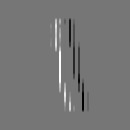

In [21]:
f_temp = """-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1""".replace('&', '').split('\\')
f = np.asarray([_.split('  ') for _ in f_temp], dtype=np.float32)
c = correlate2d(img_to_array(img1).reshape(128, 128), f)
c = np.expand_dims(c, axis=2)
img = array_to_img(c)
img

In [22]:
c.shape

(130, 130, 1)

Block Size: 1


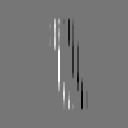

Block Size: 3


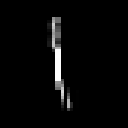

Block Size: 5


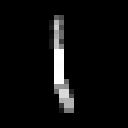

Block Size: 7


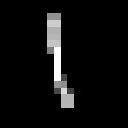

Block Size: 9


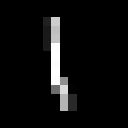

Block Size: 11


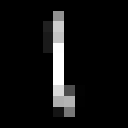

Block Size: 13


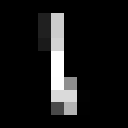

Block Size: 15


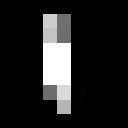

Block Size: 17


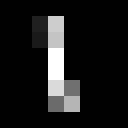

Block Size: 19


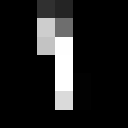

In [23]:
for i in range(1, 21, 2):
    print('Block Size:', i)
    display(array_to_img(block_reduce(c, (i, i, 1), func=np.max)).resize(size=[128, 128]))